In [29]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Downloading the data

In [2]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [4]:
len(df.columns)

19

# Computing Duration

In [5]:
df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df["duration"] = df.duration.dt.total_seconds()/60

In [6]:
df["duration"].mean()

np.float64(15.668995167330449)

In [7]:
df["duration"].std()

np.float64(42.59435124195457)

# Dropping Outliers

In [8]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

98.1220282212598

In [9]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

# One-hot encoding

In [10]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical].to_dict(orient='records')

In [27]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
print(dv.get_feature_names_out())

['DOLocationID=1' 'DOLocationID=10' 'DOLocationID=100' 'DOLocationID=101'
 'DOLocationID=102' 'DOLocationID=106' 'DOLocationID=107'
 'DOLocationID=108' 'DOLocationID=109' 'DOLocationID=11'
 'DOLocationID=111' 'DOLocationID=112' 'DOLocationID=113'
 'DOLocationID=114' 'DOLocationID=115' 'DOLocationID=116'
 'DOLocationID=117' 'DOLocationID=118' 'DOLocationID=119'
 'DOLocationID=12' 'DOLocationID=120' 'DOLocationID=121'
 'DOLocationID=122' 'DOLocationID=123' 'DOLocationID=124'
 'DOLocationID=125' 'DOLocationID=126' 'DOLocationID=127'
 'DOLocationID=128' 'DOLocationID=129' 'DOLocationID=13'
 'DOLocationID=130' 'DOLocationID=131' 'DOLocationID=132'
 'DOLocationID=133' 'DOLocationID=134' 'DOLocationID=135'
 'DOLocationID=136' 'DOLocationID=137' 'DOLocationID=138'
 'DOLocationID=139' 'DOLocationID=14' 'DOLocationID=140'
 'DOLocationID=141' 'DOLocationID=142' 'DOLocationID=143'
 'DOLocationID=144' 'DOLocationID=145' 'DOLocationID=146'
 'DOLocationID=147' 'DOLocationID=148' 'DOLocationID=149'
 '

In [12]:
print(train_dicts[0])
print(X_train[0])

{'PULocationID': '161', 'DOLocationID': '141'}
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 515)>
  Coords	Values
  (0, 43)	1.0
  (0, 325)	1.0


In [13]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3009173, 515)


### count unique entries of start and end

In [31]:
print(len(np.unique(df.PULocationID)))
print(len(np.unique(df.DOLocationID)))

255
260


# Training a model

In [14]:
target = 'duration'
y_train = df[target].values

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, y_pred)}')

Train RMSE: 7.649262060509152


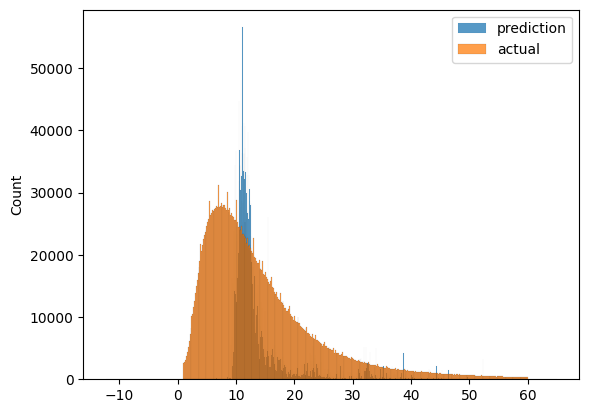

In [20]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

# Evaluating the model

In [21]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df


In [22]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [23]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [24]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [25]:
y_pred = lr.predict(X_val)

In [26]:
print(f'Val RMSE: {root_mean_squared_error(y_val, y_pred)}')

Val RMSE: 7.811819098973374
